# Передбачення зарплат на IT-ринку України

У цьому завданні ви працюватимете з реальними даними з [зарплатного опитування DOU.ua за травень 2016р](https://dou.ua/lenta/articles/salary-report-may-june-2016/). Ви реалізуєте зважену лінійну регресію, яка передбачає зарплати Java-інженерів, та навчите свою модель за допомогою градієнтного спуску.

Заповніть пропущений код в розділі «Моделювання» (позначено коментарями) та запустіть розділ «Тестування», щоб перевірити його правильність.

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [66]:
np.random.seed(42)

In [67]:
%matplotlib inline

In [68]:
%load_ext ipython_unittest

The ipython_unittest extension is already loaded. To reload it, use:
  %reload_ext ipython_unittest


## Підготовка даних

In [69]:
df_salaries = pd.read_csv("data/2016_may_final.csv")

Оберемо тільки Java-інженерів з-поміж усіх респондентів.

In [70]:
df_java = pd.DataFrame(df_salaries[(df_salaries["Язык.программирования"] == "Java") &
                                   (df_salaries["cls"] == "DEV")])

Перейменуємо деякі колонки:

In [71]:
df_java.rename(
    columns={
        "exp": "TotalExperience",
        "loc": "Location"
    },
    inplace=True
)

Закодуємо рівень англійської мови числами від 1 (найнижчий) до 5 (найвищий):

In [72]:
df_java["EnglishLevel"] = df_java["Уровень.английского"].map({
    "элементарный": 1,
    "ниже среднего": 2,
    "средний": 3,
    "выше среднего": 4,
    "продвинутый": 5
})

Закодуємо колонку Location (найбільші IT-міста або "other") за допомогою one-hot encoding:

In [73]:
city_columns = [
    "LocationOther",
    "LocationDnipro",
    "LocationKyiv",
    "LocationLviv",
    "LocationOdesa",
    "LocationKharkiv"
]
df_java[city_columns] = pd.get_dummies(df_java["Location"])

In [74]:
df_java.head()

,N,Должность,Язык.программирования,Специализация,Общий.опыт.работы,Опыт.работы.на.текущем.месте,Зарплата.в.месяц,Изменение.зарплаты.за.12.месяцев,Город,Размер.компании,...,salary,Валюта,cls,EnglishLevel,LocationOther,LocationDnipro,LocationKyiv,LocationLviv,LocationOdesa,LocationKharkiv
5,6,Junior Software Engineer,Java,NaN,0.5,0.5,500,100,Черновцы,до 50 человек,...,500,NaN,DEV,3,1,0,0,0,0,0
7,8,Software Engineer,Java,NaN,5,0.25,1600,-400,Киев,до 50 человек,...,1600,NaN,DEV,1,0,0,1,0,0,0
17,18,Junior Software Engineer,Java,NaN,меньше 3 месяцев,меньше 3 месяцев,600,0,Киев,свыше 1000 человек,...,600,NaN,DEV,3,0,0,1,0,0,0
27,28,Senior Software Engineer,Java,NaN,4,1,3400,1000,Киев,до 200 человек,...,3400,NaN,DEV,3,0,0,1,0,0,0
28,29,Senior Software Engineer,Java,NaN,6,0.5,2880,850,Киев,до 200 человек,...,2880,NaN,DEV,4,0,0,1,0,0,0


Відберемо такі ознаки:

* Загальна кількість років досвіду
* Рівень англійської мови
* Місто

In [75]:
feature_columns = ["TotalExperience", "EnglishLevel"] + city_columns
df_X = df_java[feature_columns]
df_y = df_java[["salary"]]

In [76]:
print("X shape:", df_X.shape)

X shape: (929, 8)


In [77]:
df_X.head(10)

,TotalExperience,EnglishLevel,LocationOther,LocationDnipro,LocationKyiv,LocationLviv,LocationOdesa,LocationKharkiv
5,0.5,3,1,0,0,0,0,0
7,5.0,1,0,0,1,0,0,0
17,0.0,3,0,0,1,0,0,0
27,4.0,3,0,0,1,0,0,0
28,6.0,4,0,0,1,0,0,0
39,3.0,4,0,1,0,0,0,0
46,2.0,4,0,0,0,0,0,1
49,3.0,3,0,0,1,0,0,0
59,2.0,3,0,0,0,0,0,1
89,1.0,5,0,0,1,0,0,0


In [78]:
df_y.head(10)

,salary
5,500
7,1600
17,600
27,3400
28,2880
39,1425
46,1700
49,1800
59,1235
89,1200


Розділимо вибірку на навчальну та тестову:

In [79]:
training_set_size = 0.8

In [80]:
dataset_assignment = np.random.uniform(size=len(df_X))

X_train = df_X[dataset_assignment <= training_set_size].values
y_train = df_y[dataset_assignment <= training_set_size].values.flatten()

X_test = df_X[dataset_assignment > training_set_size].values
y_test = df_y[dataset_assignment > training_set_size].values.flatten()

Щоб градієнтний спуск швидше збігався, нормалізуємо навчальну вибірку так, щоб кожна ознака мала $\mu = 0, \sigma = 1$:

$ x' = \frac{x - \bar{x}}{\sigma}$

In [81]:
feature_means = np.average(X_train, axis=0)
feature_sigmas = np.std(X_train, axis=0)

In [82]:
X_train = (X_train - feature_means) / feature_sigmas
X_test = (X_test - feature_means) / feature_sigmas

Додаємо уявну ознаку $x_0 = 1$ (intercept term).

In [83]:
if not np.all(X_train[:, 0] == 1):
    X_train = np.insert(X_train, 0, values=1, axis=1)
    
if not np.all(X_test[:, 0] == 1):
    X_test = np.insert(X_test, 0, values=1, axis=1)

In [84]:
print("X train: ", X_train.shape)
print("y train: ", y_train.shape)
print()
print("X test:  ", X_test.shape)
print("y test:  ", y_test.shape)

X train:  (741, 9)
y train:  (741,)

X test:   (188, 9)
y test:   (188,)


## Моделювання

Реалізуйте функцію гіпотези лінійної регресії в матричній формі.

In [85]:
def predict_linear(theta, X):
    # Compute the hypothesis function for linear regression.
    return np.dot(X, theta)

Реалізуйте функцію зважування всіх навчальних прикладів $x^{(i)}$, якщо нам дана точка передбачення $x$.

##### If x_i is a scalar:
$$ w^i = exp(\frac{-(x^i - x)^2}{2\tau^2}) $$
##### If x_i is a vector:
$$ w^i = exp(\frac{-(x^i - x)^T \cdot (x^i - x)}{2\tau^2}) $$

In [211]:
def get_example_weights(X, x_pred, tau):
    # Compute the weight for each example, given the
    # prediction point (x_pred).
    weights = np.array([])
    for i in range(X.shape[0]):
        val = np.exp(-np.dot((X[i] - x_pred).T, (X[i] - x_pred))/(2*tau**2))
        weights = np.insert(weights, i, val)
    
    return weights

Реалізуйте функцію втрат зваженої лінійної регресії. Подумайте, як обчислити цей вираз відразу в матричному вигляді.

$$ J(\theta) = (X\theta - \hat{y})^T W(X\theta - \hat{y}) $$

In [258]:
def create_W(weights):
    w_size = weights.shape[0]
    W = np.zeros((w_size, w_size))
    for i in range(w_size):
        W[i, i] = weights[i]
    return W

def cost_function(theta, X, y, weights):
    # Given the currently learned model weights (theta),
    # compute the overall loss on the training set (X),
    # taking the weights into account.
    m = len(X)
    W = create_W(weights)
    
    br_2 = (np.dot(X, theta.T) - y.T)
    br_1 = (np.dot(X, theta.T) - y.T).T # br_2 TODO: hh
    
    return (1/(2*m)) * np.dot(np.dot(br_1, W), br_2)

Реалізуйте обчислення градієнта функції втрат зваженої лінійної регресії. Подумайте, як обчислити цей вираз відразу в матричному вигляді.

$$\frac{\partial}{\partial \theta_j} J(\theta) = \dfrac{1}{m}\sum_{i=1}^{m}\left( h_\theta(x^{(i)}) - y^{(i)} \right) w^{(i)} $$

In [259]:
def cost_function_gradient(theta, X, y, weights):
    # Given the currently learned model weights (theta),
    # compute the gradient of the cost function on the
    # training set (X), taking the weights into account.
    m = len(X)
    W = create_W(weights)
    lin_reg_predictor = predict_linear(theta, X)

    return (1/m) * np.dot(np.dot(X.T, W), (lin_reg_predictor - y))

Реалізуйте один крок градієнтного спуску.

In [262]:
def update_model_weights(theta, learning_rate, cost_gradient):
    # Given the learning rate and the gradient of the
    # cost function, take one gradient descent step and
    # return the updated vector theta.
    theta = theta - learning_rate * cost_gradient
    
    return theta

**Навчаємо модель:**

In [268]:
def gradient_descent(X, y, weights, loss_fun, grad_fun, learning_rate, convergence_threshold, max_iters, verbose=False):
    theta = np.zeros(X.shape[1])
    losses = []
    
    for i in range(max_iters):
        loss = loss_fun(theta, X, y, weights)
        losses.append(loss)
        
        if verbose:
            print("Iteration: {0:3} Loss: {1}".format(i + 1, loss))

        if len(losses) > 2 and np.abs(losses[-1] - losses[-2]) <= convergence_threshold:
            break
        
        grad = grad_fun(theta, X, y, weights)
        theta = update_model_weights(theta, learning_rate, grad)
        
    return theta, np.array(losses)

## Передбачення нових даних

In [270]:
def predict_weighted_linear(X, y, x_pred, verbose=False):
    weights = get_example_weights(X, x_pred, tau=0.1)
    theta, losses = gradient_descent(
        X,
        y,
        weights,
        loss_fun=cost_function,
        grad_fun=cost_function_gradient,
        learning_rate=0.005,
        convergence_threshold=0.0001,
        max_iters=500,
        verbose=verbose
    )
    return predict_linear(theta, x_pred)

In [271]:
x_pred = X_train[4]

In [272]:
predicted = predict_weighted_linear(X_train, y_train, x_pred, verbose=True)

Iteration:   1 Loss: 2051.275762424122
Iteration:   2 Loss: 2050.49351072097
Iteration:   3 Loss: 2049.711566651771
Iteration:   4 Loss: 2048.9299300955427
Iteration:   5 Loss: 2048.1486009313508
Iteration:   6 Loss: 2047.3675790383077
Iteration:   7 Loss: 2046.586864295574
Iteration:   8 Loss: 2045.8064565823574
Iteration:   9 Loss: 2045.0263557779133
Iteration:  10 Loss: 2044.2465617615442
Iteration:  11 Loss: 2043.4670744126004
Iteration:  12 Loss: 2042.6878936104802
Iteration:  13 Loss: 2041.909019234629
Iteration:  14 Loss: 2041.1304511645385
Iteration:  15 Loss: 2040.3521892797496
Iteration:  16 Loss: 2039.5742334598485
Iteration:  17 Loss: 2038.7965835844707
Iteration:  18 Loss: 2038.0192395332986
Iteration:  19 Loss: 2037.2422011860604
Iteration:  20 Loss: 2036.4654684225336
Iteration:  21 Loss: 2035.689041122542
Iteration:  22 Loss: 2034.9129191659574
Iteration:  23 Loss: 2034.1371024326966
Iteration:  24 Loss: 2033.3615908027275
Iteration:  25 Loss: 2032.586384156061
Iteratio

Iteration: 396 Loss: 1765.037715237477
Iteration: 397 Loss: 1764.3680315756176
Iteration: 398 Loss: 1763.6986112783907
Iteration: 399 Loss: 1763.0294542422237
Iteration: 400 Loss: 1762.3605603635847
Iteration: 401 Loss: 1761.6919295389823
Iteration: 402 Loss: 1761.0235616649659
Iteration: 403 Loss: 1760.3554566381256
Iteration: 404 Loss: 1759.6876143550926
Iteration: 405 Loss: 1759.020034712538
Iteration: 406 Loss: 1758.3527176071746
Iteration: 407 Loss: 1757.6856629357544
Iteration: 408 Loss: 1757.0188705950704
Iteration: 409 Loss: 1756.3523404819575
Iteration: 410 Loss: 1755.6860724932892
Iteration: 411 Loss: 1755.0200665259817
Iteration: 412 Loss: 1754.3543224769896
Iteration: 413 Loss: 1753.6888402433096
Iteration: 414 Loss: 1753.0236197219785
Iteration: 415 Loss: 1752.358660810072
Iteration: 416 Loss: 1751.6939634047094
Iteration: 417 Loss: 1751.0295274030475
Iteration: 418 Loss: 1750.3653527022861
Iteration: 419 Loss: 1749.7014391996627
Iteration: 420 Loss: 1749.0377867924578
Ite

Оцінимо, наскільки модель помиляється на тестовій вибірці:

In [273]:
y_test_pred = np.array([predict_weighted_linear(X_test, y_test, X_test[i]) for i in range(len(y_test))])

In [274]:
df_residuals = pd.DataFrame(y_test - y_test_pred, columns=["residual"])

[Text(0.5, 1.0, 'Error Distribution')]

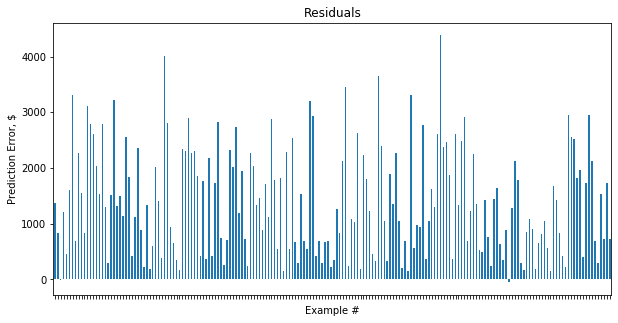

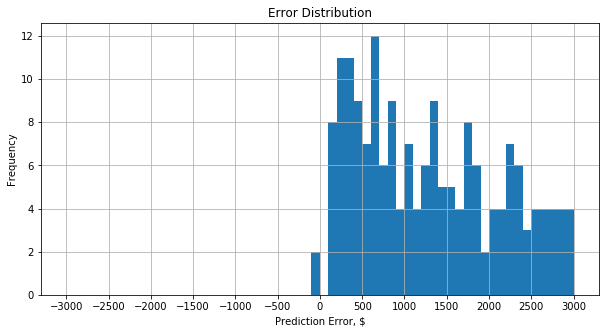

In [275]:
ax = df_residuals.plot.bar(figsize=(10, 5))
ax.legend().remove()
ax.get_xaxis().set(ticklabels=[])
ax.set(xlabel="Example #")
ax.set(ylabel="Prediction Error, $")
ax.set(title="Residuals")

bins = np.arange(-3000, 3001, 100)
ticks = np.arange(-3000, 3001, 500)

ax = df_residuals.hist(bins=bins, figsize=(10, 5))[0][0]
ax.set(xticks=ticks)
ax.set(xlabel="Prediction Error, $")
ax.set(ylabel="Frequency")
ax.set(title="Error Distribution")

## Тестування

Запустіть комірку нижче, щоб перевірити правильність вашого коду:

In [267]:
%%unittest_main

class WLRTests(unittest.TestCase):

    x = np.array([1, -0.5, 3, 1])
    X = np.array([
        [1, -0.5, 3, 1],
        [2, 8, -0.33, 5],
        [0, 0, 0, 0]
    ])
    y = np.array([40, 100, 12])
    theta = np.array([2, 5, 7, 9])
    eps = 0.001

    def assertFloatEquals(self, a, b):
        self.assertTrue(np.abs(a - b) < self.eps)
    
    def assertArrayEquals(self, a, b):
        a = np.array(a)
        b = np.array(b)
        self.assertEqual(a.shape, b.shape)
        self.assertTrue(np.all(np.abs(a - b) < self.eps))
    
    def test_predict_linear_should_compute_correct_prediction_for_1_example(self):
        expected = 29.5
        actual = predict_linear(self.theta, self.x)
        self.assertEqual(actual, expected)
    
    def test_predict_linear_should_compute_correct_predictions_for_multiple_examples(self):
        expected = [29.5, 86.69, 0]
        actual = (predict_linear(self.theta, self.X))
        self.assertArrayEquals(actual, expected)

    def test_get_example_weights_should_return_properly_shaped_vector(self):
        weights = get_example_weights(self.X, self.x, tau=5)
        self.assertTrue(weights.shape[0] == self.X.shape[0])

    def test_get_example_weights_should_compute_correct_weights(self):
        expected = [1.000, 0.134, 0.798]
        actual = get_example_weights(self.X, self.x, tau=5)
        self.assertArrayEquals(actual, expected)
               
    def test_cost_function_should_compute_correct_cost_unweighted(self):
        weights = np.ones(self.X.shape[0])
        expected = 71.901
        actual = cost_function(self.theta, self.X, self.y, weights)
        self.assertFloatEquals(actual, expected) 

    def test_cost_function_should_compute_correct_cost_weighted(self):
        weights = np.array([0.5, 0.1, 0.28])
        expected = 18.860
        actual = cost_function(self.theta, self.X, self.y, weights)
        self.assertFloatEquals(actual, expected)

    def test_cost_gradient_should_return_properly_shaped_vector(self):
        weights = np.ones(self.X.shape[0])
        grad = cost_function_gradient(self.theta, self.X, self.y, weights)
        self.assertTrue(grad.shape == self.theta.shape)
        
    def test_cost_gradient_should_compute_correct_gradient_unweighted(self):
        weights = np.ones(self.X.shape[0])
        expected = [-12.373, -33.743, -9.036, -25.683]
        actual = cost_function_gradient(self.theta, self.X, self.y, weights)
        self.assertTrue(np.all(np.abs(actual - expected) < 1e-2))
    
    def test_cost_gradient_should_compute_correct_gradient_weighted(self):
        weights = np.array([0.5, 0.1, 0.28])
        expected = [-2.637, -2.674, -5.103, -3.968]
        actual = cost_function_gradient(self.theta, self.X, self.y, weights)
        self.assertTrue(np.all(np.abs(actual - expected) < 1e-2))
        
    def test_update_model_weights_should_not_update_when_gradient_is_zero(self):
        grad = np.zeros(self.theta.shape[0])
        theta_new = update_model_weights(self.theta, learning_rate=1, cost_gradient=grad)
        self.assertArrayEquals(theta_new, self.theta)
    
    def test_update_model_weights_should_update_with_complete_gradient_if_learning_rate_is_one(self):
        grad = np.array([1.35, -0.89, 0.16, 0.98])
        expected = [0.65, 5.89, 6.84, 8.02]
        actual = update_model_weights(self.theta, learning_rate=1, cost_gradient=grad)
        self.assertArrayEquals(actual, expected)
    
    def test_update_model_weights_should_take_learning_rate_into_account(self):
        grad = np.array([1.35, -0.89, 0.16, 0.98])
        expected = [1.730, 5.178, 6.968, 8.804]
        actual = update_model_weights(self.theta, learning_rate=0.2, cost_gradient=grad)
        self.assertArrayEquals(actual, expected)

Success

............
----------------------------------------------------------------------
Ran 12 tests in 0.001s

OK


<unittest.runner.TextTestResult run=12 errors=0 failures=0>